# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
def get_datetimes(df):
    return pd.to_datetime(df.columns.values[1:], format='%Y-%m')

In [2]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 
                                  'State', 'Metro', 'CountyName', 
                                  'SizeRank'], var_name='time')
    
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_csv('zillow_data.csv')
df.head(1)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,...,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12,2018-01,2018-02,2018-03,2018-04
0,84654,60657,Chicago,IL,Chicago,Cook,1,334200.0,335400.0,336500.0,...,1005500,1007500,1007800,1009600,1013300,1018700,1024400,1030700,1033800,1030600


In [5]:
melt_df = melt_data(df)
# melt_df.set_index('time', inplace=True)
melt_df.drop(['RegionID', 'SizeRank'], inplace=True, axis=1)
melt_df.tail()

,RegionName,City,State,Metro,CountyName,time,value
3901590,1338,Ashfield,MA,Greenfield Town,Franklin,2018-04-01,209300.0
3901591,3293,Woodstock,NH,Claremont,Grafton,2018-04-01,225800.0
3901592,40404,Berea,KY,Richmond,Madison,2018-04-01,133400.0
3901593,81225,Mount Crested Butte,CO,NaN,Gunnison,2018-04-01,664400.0
3901594,89155,Mesquite,NV,Las Vegas,Clark,2018-04-01,357200.0


In [6]:
# sort by zip code and date
sorted_melt = melt_df.sort_values(['RegionName', 'time'])
sorted_melt.head()

,RegionName,City,State,Metro,CountyName,time,value
5850,1001,Agawam,MA,Springfield,Hampden,1996-04-01,113100.0
20573,1001,Agawam,MA,Springfield,Hampden,1996-05-01,112800.0
35296,1001,Agawam,MA,Springfield,Hampden,1996-06-01,112600.0
50019,1001,Agawam,MA,Springfield,Hampden,1996-07-01,112300.0
64742,1001,Agawam,MA,Springfield,Hampden,1996-08-01,112100.0


# Step 2: Data Preprocessing

In [7]:
# create a new dataframe with the difference between the values in recent years after the housing crisis
series09 = df['2009-04']
series18 = df['2018-04']
zipcode = df['RegionName']

# add the difference and noramalize it
diff_df = pd.concat([zipcode, series09, series18], axis=1)
diff_df['diff'] = (diff_df['2018-04'] - diff_df['2009-04'])/diff_df['2009-04']*100

# diff_df.hist('diff',bins=20, density=True)

In [8]:
cutoffs = [diff_df['diff'].quantile(0.05),
          diff_df['diff'].quantile(0.95)]
cutoffs

[-7.3194206740281125, 69.3212732041648]

In [9]:
# # Scale the values
# scaler = MinMaxScaler()
# melt_df[['value']] = scaler.fit_transform(melt_df[['value']])

In [14]:
# grab the zip codes that exist between the cutoff values
zips_model_1 = diff_df[diff_df['diff']<cutoffs[0]]['RegionName']
zips_model_10 = diff_df[diff_df['diff']>cutoffs[1]]['RegionName']

In [35]:
high_return = melt_df.loc[melt_df['RegionName'].isin(list(zips_model_10))]
low_return = melt_df.loc[melt_df['RegionName'].isin(list(zips_model_1))]

low_return

,RegionName,City,State,Metro,CountyName,time,value
74,60619,Chicago,IL,Chicago,Cook,1996-04-01,76400.0
150,60620,Chicago,IL,Chicago,Cook,1996-04-01,71900.0
231,60649,Chicago,IL,Chicago,Cook,1996-04-01,77400.0
255,23666,Hampton,VA,Virginia Beach,Hampton City,1996-04-01,88300.0
316,21215,Baltimore,MD,Baltimore,Baltimore City,1996-04-01,53500.0
367,21222,Dundalk,MD,Baltimore,Baltimore,1996-04-01,76900.0
391,31907,Columbus,GA,Columbus,Muscogee,1996-04-01,69600.0
416,6516,West Haven,CT,New Haven,New Haven,1996-04-01,96500.0
545,6511,New Haven,CT,New Haven,New Haven,1996-04-01,89800.0
605,21218,Baltimore,MD,Baltimore,Baltimore City,1996-04-01,44700.0


In [40]:
# dataframe for the very high returns to model
high_df = high_return.groupby('time')[['value']].mean()
low_df = low_return.groupby('time')[['value']].mean()

,value
time,
2009-02-01,211306.506365
2009-03-01,210021.357850
2009-04-01,208752.050919
2009-05-01,207233.380481
2009-06-01,205494.059406
2009-07-01,203935.643564
2009-08-01,202530.551627
2009-09-01,201245.544554
2009-10-01,200108.910891


# Step 4: EDA and Visualization
Perform basic EDA as you would building any model, then create at least 3 visualizations.  At least one of the visualizations should have time on the x-axis.  Axes should be labeled and any text should be legible.

Text(0.5, 1.0, 'low')

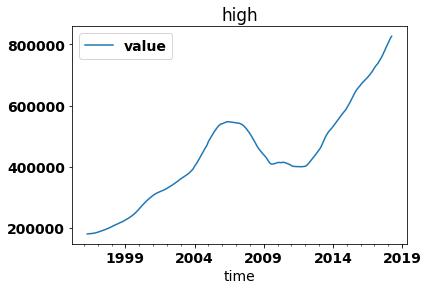

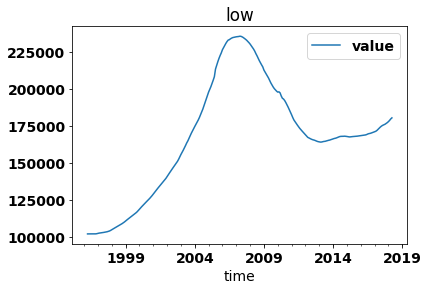

In [66]:

font = {'family' : 'normal',
        'size'   : 14}

plt.rc('font', **font)
high_df.plot()
plt.title('high')
low_df.plot()
plt.title('low')

# NOTE: if you visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

In [67]:
# dickey fuller test
from statsmodels.tsa.stattools import adfuller
def dickey_fuller(array):
    test = adfuller(array)
    output = pd.Series(test[0:4], index = ['Test Stat','p-value','# Lags used', '# of obs'])
    return output

In [68]:
output_high = dickey_fuller(high_df['value'])

In [69]:
output_high

Test Stat       -1.003367
p-value          0.752034
# Lags used      1.000000
# of obs       263.000000
dtype: float64

In [70]:
output_low = dickey_fuller(low_df['value'])

In [71]:
output_low

Test Stat       -2.452470
p-value          0.127471
# Lags used     12.000000
# of obs       252.000000
dtype: float64

In [88]:
# try log transforming the data
log_high = pd.Series(np.log(high_df['value']), index=high_df.index)

In [94]:
dickey_fuller(log_high)

Test Stat       -1.825685
p-value          0.367786
# Lags used      2.000000
# of obs       262.000000
dtype: float64

In [95]:
# our p-values are larger than 0.05, so we cannot reject the Null and our data is not stationary
# so let's difference our data

diff_high = log_high.diff()

In [98]:
diff_high

time
1996-05-01    0.001635
1996-06-01    0.001791
1996-07-01    0.001958
1996-08-01    0.002273
1996-09-01    0.002705
1996-10-01    0.003471
1996-11-01    0.004078
1996-12-01    0.005593
1997-01-01    0.006763
1997-02-01    0.006678
1997-03-01    0.006079
1997-04-01    0.006545
1997-05-01    0.006906
1997-06-01    0.007243
1997-07-01    0.007508
1997-08-01    0.007686
1997-09-01    0.007856
1997-10-01    0.008228
1997-11-01    0.008451
1997-12-01    0.009489
1998-01-01    0.010070
1998-02-01    0.009374
1998-03-01    0.008313
1998-04-01    0.008296
1998-05-01    0.008126
1998-06-01    0.008042
1998-07-01    0.007900
1998-08-01    0.007814
1998-09-01    0.007791
1998-10-01    0.008092
                ...   
2015-11-01    0.006634
2015-12-01    0.006410
2016-01-01    0.007411
2016-02-01    0.007497
2016-03-01    0.006098
2016-04-01    0.005623
2016-05-01    0.006097
2016-06-01    0.005542
2016-07-01    0.005557
2016-08-01    0.006333
2016-09-01    0.006805
2016-10-01    0.006783
2016-1

In [96]:
diff_high.dropna(inplace=True)

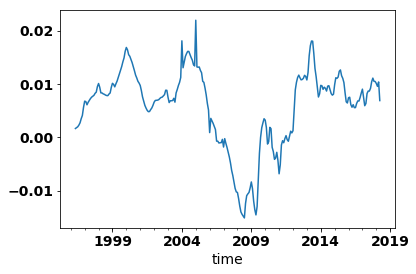

In [97]:
diff_high.plot()

In [86]:
dickey_fuller(diff_high['value'])

Test Stat       -1.749221
p-value          0.405947
# Lags used      1.000000
# of obs       262.000000
dtype: float64

# Step 5: ARIMA Modeling
Be sure to validate your model.  Make a forecast for the future and describe the trend.

# Step 6: Interpreting Results
Give a detailed interpretation of results including the relationship between the inputs and output of the model.